In [1]:
%autosave 0

Autosave disabled


In [1]:
!python -V

Python 3.9.13


In [3]:

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [4]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.9.1'

In [7]:
model = keras.models.load_model('xception_v4_1_06_0.894.h5') 

In [8]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.applications.xception import preprocess_input

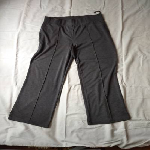

In [10]:
load_img('pants.jpg', target_size=(150, 150))

In [11]:
img = load_img('pants.jpg', target_size=(299, 299))

x = np.array(img)
X = np.array([x])

X = preprocess_input(X)

In [12]:
X.shape

(1, 299, 299, 3)

In [14]:
preds = model.predict(X)
preds

1/1 [==============================] - 0s 21ms/step


array([[-2.2665973, -4.6578784, -0.967889 , -0.6912958,  8.8173   ,
        -2.100858 , -3.3737097,  2.0933886, -3.089316 , -3.1377769]],
      dtype=float32)

In [15]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]
dict(zip(classes, preds[0]))

{'dress': -2.2665973,
 'hat': -4.6578784,
 'longsleeve': -0.967889,
 'outwear': -0.6912958,
 'pants': 8.8173,
 'shirt': -2.100858,
 'shoes': -3.3737097,
 'shorts': 2.0933886,
 'skirt': -3.089316,
 't-shirt': -3.1377769}

#### TF-Lite 

__Convert Keras into TF-Lite__

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('clothing-model-1.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp_vk4l1db/assets


INFO:tensorflow:Assets written to: /tmp/tmp_vk4l1db/assets
2023-11-22 21:01:19.386637: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-11-22 21:01:19.386683: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-11-22 21:01:19.386863: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp_vk4l1db
2023-11-22 21:01:19.415159: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-11-22 21:01:19.415202: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmp_vk4l1db
2023-11-22 21:01:19.534294: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-11-22 21:01:20.066165: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmp_vk4l1db
2023-11-22 21:01:20.280529: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

In [18]:
!ls -lh

total 243M
-rw-r--r-- 1 jovyan jovyan 81M Nov 22 21:01 clothing-model-1.tflite
-rw-r--r-- 1 jovyan jovyan 81M Nov 22 21:03 clothing-model.tflite
-rw-r--r-- 1 jovyan jovyan 23K Nov 22 20:55 pants.jpg
-rw-r--r-- 1 jovyan jovyan 47K Nov 22 21:03 tf_lite.ipynb
-rw-rw-r-- 1 jovyan jovyan 83M Nov 20 17:32 xception_v4_1_06_0.894.h5


### Use TF-Lite

In [20]:
import tensorflow.lite as tflite

In [21]:
interpreter = tflite.Interpreter(model_path='clothing-model.tflite')
# memory allocation
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [22]:
interpreter.get_input_details()

[{'name': 'serving_default_input_2:0',
  'index': 0,
  'shape': array([  1, 299, 299,   3], dtype=int32),
  'shape_signature': array([ -1, 299, 299,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [23]:
interpreter.get_input_details()[0] # pull index -> 0

{'name': 'serving_default_input_2:0',
 'index': 0,
 'shape': array([  1, 299, 299,   3], dtype=int32),
 'shape_signature': array([ -1, 299, 299,   3], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [24]:
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [25]:
# make predictions
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [26]:
# compare with previous results
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

dict(zip(classes, preds[0]))

{'dress': -2.266599,
 'hat': -4.6578803,
 'longsleeve': -0.9678885,
 'outwear': -0.69129413,
 'pants': 8.817301,
 'shirt': -2.1008554,
 'shoes': -3.373714,
 'shorts': 2.0933902,
 'skirt': -3.0893178,
 't-shirt': -3.13778}